In [203]:
# Consolidated Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.impute import KNNImputer
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import time
import folium
import branca.colormap as cm
from folium.plugins import HeatMap
from scipy import stats

In [204]:
# Load Airbnb listings dataset
listings_df = pd.read_csv('../data/listings.csv')
# Load restaurant dataset
restaurants_df = pd.read_csv('../data/nashville_restaurants.csv')
# Load business dataset
businesses_df = pd.read_csv('../data/nashville_businesses.csv')
# Load GeoJSON file for neighborhoods
geojson_path = '../data/neighbourhoods.geojson'
neighborhoods_gdf = gpd.read_file(geojson_path)

# Code by Alara & Mary
# Handle Missing Values for Airbnb Listings
print("Missing Values in Airbnb Listings:")
print(listings_df.isnull().sum())


Missing Values in Airbnb Listings:
id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group               8994
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                             2339
minimum_nights                       0
number_of_reviews                    0
last_review                        945
reviews_per_month                  945
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                           8608
dtype: int64


In [205]:
# Fill non-essential missing values
listings_df['reviews_per_month'] = listings_df['reviews_per_month'].fillna(0)  # Alara
listings_df['neighbourhood_group'] = listings_df['neighbourhood_group'].fillna('Unknown')  # Mary
listings_df['host_name'] = listings_df['host_name'].fillna('Unknown')  # Mary
listings_df['last_review'] = listings_df['last_review'].fillna('No reviews')  # Mary

# Handle missing values for Listings DataFrame # Mary and Alara
columns_to_drop = ['license', 'neighbourhood_group']
listings_df = listings_df.drop(columns=[col for col in columns_to_drop if col in listings_df.columns])

# Handle Outliers in Airbnb Listings - Alara
price_upper_limit = listings_df['price'].quantile(0.95)
listings_df = listings_df[listings_df['price'] <= price_upper_limit]

# Convert price to numeric and drop invalid entries - Mary
listings_df['price'] = pd.to_numeric(listings_df['price'], errors='coerce')
listings_df = listings_df.dropna(subset=['latitude', 'longitude', 'price'])

# Clean Airbnb Listings Text Fields - Alara
listings_df['neighbourhood'] = listings_df['neighbourhood'].str.strip().str.title()
listings_df['room_type'] = listings_df['room_type'].str.strip().str.lower()



This code re-projects the `neighborhoods_gdf` GeoDataFrame to the Web Mercator coordinate system (EPSG:3857) to facilitate accurate spatial calculations. Afterward, it computes the centroids of each neighborhood polygon for labeling and spatial analysis purposes. The GeoDataFrame is then transformed back to the geographic coordinate system (EPSG:4326) for compatibility with other geographic data. Finally, the centroids are extracted into a new DataFrame, `district_centroids`, for further spatial operations and visualization.

In [206]:
# Code by Alara
# Re-project the GeoDataFrame to a projected CRS (e.g., EPSG:3857 for Web Mercator)
neighborhoods_gdf = neighborhoods_gdf.to_crs(epsg=3857)

# Calculate the centroids in the projected CRS
neighborhoods_gdf['centroid'] = neighborhoods_gdf.geometry.centroid

# If needed, transform back to the original geographic CRS (e.g., EPSG:4326 for lat/lon)
neighborhoods_gdf = neighborhoods_gdf.to_crs(epsg=4326)

# Extract the centroids for labeling purposes
district_centroids = neighborhoods_gdf[['neighbourhood', 'centroid']]

# Check the updated centroids
print(district_centroids)

   neighbourhood                          centroid
0     District 1  POINT (-9673061.600 4336833.902)
1     District 6  POINT (-9654901.145 4325013.804)
2    District 19  POINT (-9658904.868 4322596.506)
3    District 13  POINT (-9647967.556 4317446.871)
4    District 29  POINT (-9643400.314 4313989.325)
5    District 21  POINT (-9664585.236 4323467.571)
6     District 2  POINT (-9662833.077 4329361.910)
7     District 8  POINT (-9655602.637 4334407.887)
8    District 31  POINT (-9648514.527 4302470.050)
9    District 32  POINT (-9645172.538 4306857.482)
10   District 22  POINT (-9679231.276 4312679.276)
11   District 23  POINT (-9671760.091 4315069.697)
12   District 33  POINT (-9638357.397 4309917.233)
13   District 34  POINT (-9666852.124 4309888.560)
14   District 35  POINT (-9683146.439 4313606.236)
15   District 30  POINT (-9651571.605 4309933.074)
16    District 9  POINT (-9648546.551 4333493.691)
17    District 4  POINT (-9655757.235 4304667.165)
18   District 14  POINT (-96438

This code initializes a geolocator using the Nominatim service to assign approximate neighborhood names to district centroids based on latitude and longitude coordinates. After defining district locations and their corresponding coordinates, a function retrieves the nearest address for each coordinate. Additionally, a predefined mapping of district names to friendly neighborhood labels is created for easier reference. This mapping is applied to both the `neighborhoods_gdf` and `listings_df` DataFrames, ensuring consistent labeling for subsequent spatial analysis and visualization tasks.

In [207]:
# Code by Alara
# Initialize the geolocator
geolocator = Nominatim(user_agent="nashville_locator")

# Sample DataFrame with your district names and coordinates
district_centroids = pd.DataFrame({
    'neighbourhood': [
        'District 1', 'District 6', 'District 19', 'District 13', 'District 29',
        'District 21', 'District 2', 'District 8', 'District 31', 'District 32',
        'District 22', 'District 23', 'District 33', 'District 34', 'District 35',
        'District 30', 'District 9', 'District 4', 'District 14', 'District 15',
        'District 16', 'District 24', 'District 25', 'District 26', 'District 27',
        'District 28', 'District 5', 'District 7', 'District 3', 'District 10',
        'District 17', 'District 18', 'District 20', 'District 12', 'District 11'
    ],
    'latitude': [
        36.26266, 36.17707, 36.15954, 36.12218, 36.09709,
        36.34675, 36.36631, 36.21523, 36.07845, 36.14567,
        36.19836, 36.26987, 36.35781, 36.14612, 36.27614,
        36.16853, 36.14356, 36.19654, 36.12345, 36.45621,
        36.24674, 36.17556, 36.29674, 36.34567, 36.24612,
        36.28753, 36.14576, 36.21565, 36.36712, 36.21523,
        36.45623, 36.12375, 36.14562, 36.21212, 36.19865
    ],
    'longitude': [
        -86.7816, -86.73145, -86.7766, -86.7332, -86.7810,
        -86.7645, -86.7315, -86.8012, -86.7948, -86.7846,
        -86.7874, -86.7518, -86.7832, -86.7979, -86.7654,
        -86.7136, -86.7456, -86.7823, -86.7145, -86.7456,
        -86.7412, -86.7834, -86.7463, -86.7542, -86.7123,
        -86.7234, -86.7345, -86.7815, -86.7632, -86.7121,
        -86.7256, -86.7435, -86.7512, -86.7321, -86.7452
    ]
})

# Function to get the neighborhood name from coordinates
def get_neighborhood(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        return location.address if location else "Unknown"
    except Exception as e:
        return "Error: " + str(e)

# Add a new column with neighborhood names
district_centroids['approximate_location'] = district_centroids.apply(
    lambda row: get_neighborhood(row['latitude'], row['longitude']),
    axis=1
)

# Introduce a delay between requests to respect the API rate limit
time.sleep(1)

# Print the updated DataFrame
print(district_centroids)


   neighbourhood  latitude  longitude  \
0     District 1  36.26266  -86.78160   
1     District 6  36.17707  -86.73145   
2    District 19  36.15954  -86.77660   
3    District 13  36.12218  -86.73320   
4    District 29  36.09709  -86.78100   
5    District 21  36.34675  -86.76450   
6     District 2  36.36631  -86.73150   
7     District 8  36.21523  -86.80120   
8    District 31  36.07845  -86.79480   
9    District 32  36.14567  -86.78460   
10   District 22  36.19836  -86.78740   
11   District 23  36.26987  -86.75180   
12   District 33  36.35781  -86.78320   
13   District 34  36.14612  -86.79790   
14   District 35  36.27614  -86.76540   
15   District 30  36.16853  -86.71360   
16    District 9  36.14356  -86.74560   
17    District 4  36.19654  -86.78230   
18   District 14  36.12345  -86.71450   
19   District 15  36.45621  -86.74560   
20   District 16  36.24674  -86.74120   
21   District 24  36.17556  -86.78340   
22   District 25  36.29674  -86.74630   
23   District 26

In [208]:
# Approximate neighborhood locations based on research #Alara
district_locations = {
    "District 1": "Downtown Nashville",
    "District 6": "East Nashville",
    "District 19": "Vanderbilt/West End Area",
    "District 13": "12 South",
    "District 29": "Antioch",
    "District 21": "Music Row",
    "District 2": "Germantown",
    "District 8": "The Nations",
    "District 31": "Brentwood Area",
    "District 32": "Nolensville",
    "District 22": "Bellevue",
    "District 23": "Green Hills",
    "District 33": "Cane Ridge",
    "District 34": "Forest Hills",
    "District 35": "Bellevue/West Meade",
    "District 30": "Oak Hill",
    "District 9": "Bordeaux",
    "District 4": "Smyrna Area",
    "District 14": "Edgehill",
    "District 15": "Donelson",
    "District 16": "Woodbine",
    "District 24": "Belle Meade",
    "District 25": "Sylvan Park",
    "District 26": "Berry Hill",
    "District 27": "Radnor",
    "District 28": "Creive Hall",
    "District 5": "Old Hickory",
    "District 7": "Inglewood",
    "District 3": "Joelton",
    "District 10": "Madison",
    "District 17": "Wedgewood-Houston",
    "District 18": "Melrose",
    "District 20": "The Gulch",
    "District 12": "Hermitage",
    "District 11": "West End/Charlotte Pike"
}

# Ensure 'neighbourhood_name' exists in neighborhoods_gdf
if 'neighbourhood_name' not in neighborhoods_gdf.columns:
    # Map district names based on 'neighbourhood'
    neighborhoods_gdf['neighbourhood_name'] = neighborhoods_gdf['neighbourhood'].map(district_locations)
    
    # Handle any unmatched entries
    neighborhoods_gdf['neighbourhood_name'] = neighborhoods_gdf['neighbourhood_name'].fillna(neighborhoods_gdf['neighbourhood'])

# Add a new column with the approximate neighborhood names
listings_df['neighbourhood_name'] = listings_df['neighbourhood'].map(district_locations)

# Display the first few rows of the updated dataset
print(listings_df.head())

       id                                               name  host_id  \
0    6422                                    Nashville Charm    12172   
1   39870                              Close to Vanderbilt 2   171184   
2   59576     Large Main Suite near Lake *ladies only NS plz   812128   
3   72906  Vandy/Belmont/10 mins to Broadway - Sunny 800 ...   176117   
4  258817             ButterflyRoom-queen room, private bath    22296   

           host_name neighbourhood  latitude  longitude        room_type  \
0            Michele    District 6  36.17143  -86.73570     private room   
1             Evelyn   District 25  36.12466  -86.81269     private room   
2  Patricia And John   District 12  36.18940  -86.59162     private room   
3            Richard   District 18  36.13122  -86.80066  entire home/apt   
4              Diana   District 12  36.16076  -86.59151     private room   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0   43.0              30  

The code below matches the neighbourhood names for each of the businesses listed in the business data frame, utilizing coordinates and GeoDataFrame.

In [209]:
# Code by Seema
# Convert businesses_df to a GeoDataFrame
businesses_gdf = gpd.GeoDataFrame(
    businesses_df,
    geometry=gpd.points_from_xy(businesses_df['longitude'], businesses_df['latitude']),
    crs="EPSG:4326"
)

# Create district polygons using centroids and buffers
district_boundaries_gdf = gpd.GeoDataFrame(
    district_centroids,
    geometry=gpd.points_from_xy(district_centroids['longitude'], district_centroids['latitude']),
    crs="EPSG:4326"
)

# Create approximate polygons by buffering the centroids (1 km radius)
district_boundaries_gdf['geometry'] = district_boundaries_gdf.geometry.buffer(0.01)  # Adjust buffer size as needed

# Perform the spatial join and reset the index to avoid duplicate labels
businesses_with_neighborhoods = gpd.sjoin(
    businesses_gdf,
    district_boundaries_gdf[['neighbourhood', 'geometry']],
    how="left",
    predicate="within"
).reset_index()

# Map the friendly district names
businesses_with_neighborhoods['neighbourhood_name'] = businesses_with_neighborhoods['neighbourhood'].map(district_locations)

# Align with businesses_df by index
businesses_df = businesses_df.reset_index(drop=True)
businesses_df['neighbourhood_name'] = businesses_with_neighborhoods['neighbourhood_name']

# Filter out rows with known and missing neighborhood names
known_neighborhoods = businesses_df.dropna(subset=['neighbourhood_name'])
missing_neighborhoods = businesses_df[businesses_df['neighbourhood_name'].isna()]

# Prepare features and labels for KNN
X_train = known_neighborhoods[['latitude', 'longitude']]
y_train = known_neighborhoods['neighbourhood_name']

# Apply KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict missing values
X_missing = missing_neighborhoods[['latitude', 'longitude']]
predicted_neighborhoods = knn.predict(X_missing)

# Fill missing neighborhoods
businesses_df.loc[businesses_df['neighbourhood_name'].isna(), 'neighbourhood_name'] = predicted_neighborhoods

# Display the updated DataFrame
print(businesses_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6971 entries, 0 to 6970
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            6971 non-null   float64
 1   longitude           6971 non-null   float64
 2   neighbourhood_name  2302 non-null   object 
dtypes: float64(2), object(1)
memory usage: 163.5+ KB
None
    latitude  longitude        neighbourhood_name
0  36.208102 -86.768170               Nolensville
1  36.248570 -86.719986                    Radnor
2  36.159886 -86.773197  Vanderbilt/West End Area
3  36.148371 -86.798895              Forest Hills
4  36.103614 -86.816268               Belle Meade
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6971 entries, 0 to 6970
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   business_id         6971 non-null   object 
 1   name                6971 non-nu

/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/102624385.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  district_boundaries_gdf['geometry'] = district_boundaries_gdf.geometry.buffer(0.01)  # Adjust buffer size as needed


The code below matches the neighbourhood names for each of the restaurants listed in the restuarant data frame, utilizing coordinates and GeoDataFrame.

In [220]:
# Code by Seema
# Convert restaurants_df to a GeoDataFrame
restaurants_gdf = gpd.GeoDataFrame(
    restaurants_df,
    geometry=gpd.points_from_xy(restaurants_df['longitude'], restaurants_df['latitude']),
    crs="EPSG:4326"
)

# Perform the spatial join to assign neighborhoods
restaurants_with_neighborhoods = gpd.sjoin(
    restaurants_gdf,
    district_boundaries_gdf[['neighbourhood', 'geometry']],
    how="left",
    predicate="within"
).reset_index()

# Map the friendly district names
restaurants_with_neighborhoods['neighbourhood_name'] = restaurants_with_neighborhoods['neighbourhood'].map(district_locations)

#  Handle Missing Neighborhoods with KNN
known_neighborhoods = restaurants_with_neighborhoods.dropna(subset=['neighbourhood_name'])
missing_neighborhoods = restaurants_with_neighborhoods[restaurants_with_neighborhoods['neighbourhood_name'].isna()]

# Prepare features and labels for KNN
X_train = known_neighborhoods[['latitude', 'longitude']]
y_train = known_neighborhoods['neighbourhood_name']

# Apply KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict missing values
X_missing = missing_neighborhoods[['latitude', 'longitude']]
predicted_neighborhoods = knn.predict(X_missing)

# Fill missing neighborhoods
restaurants_with_neighborhoods.loc[
    restaurants_with_neighborhoods['neighbourhood_name'].isna(), 
    'neighbourhood_name'
] = predicted_neighborhoods

restaurants_df['neighbourhood_name'] = restaurants_with_neighborhoods['neighbourhood_name']

# Display the updated DataFrame
print(restaurants_df.info())

# Drop remaining few rows with any NaN values in the DataFrame from columns that are not used for analysis
restaurants_df.dropna(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   business_id         2503 non-null   object 
 1   name                2503 non-null   object 
 2   address             2465 non-null   object 
 3   city                2503 non-null   object 
 4   state               2503 non-null   object 
 5   postal_code         2501 non-null   float64
 6   latitude            2503 non-null   float64
 7   longitude           2503 non-null   float64
 8   stars               2503 non-null   float64
 9   review_count        2503 non-null   int64  
 10  is_open             2503 non-null   int64  
 11  attributes          2464 non-null   object 
 12  categories          2503 non-null   object 
 13  hours               2155 non-null   object 
 14  neighbourhood_name  2503 non-null   object 
dtypes: float64(4), int64(2), object(9)
memory usage: 293.4+

The code below confirms that all missingness has been handled and cleaned from the raw data.

In [221]:
print(listings_df.isnull().sum())

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
neighbourhood_name                0
walkability_distance_meters       0
geometry                          0
dtype: int64


In [222]:
print(restaurants_df.isnull().sum())

business_id           0
name                  0
address               0
city                  0
state                 0
postal_code           0
latitude              0
longitude             0
stars                 0
review_count          0
is_open               0
attributes            0
categories            0
hours                 0
neighbourhood_name    0
dtype: int64


This collection of visualizations explores key aspects of Airbnb listings in Nashville, focusing on price distributions, neighborhood popularity, and room type variations. The price distribution histogram with a KDE curve highlights the overall spread and central tendencies of listing prices. A bar plot reveals the top 10 neighborhoods by the number of listings, providing insights into the most active areas. The boxplot showcases price variations across neighborhoods, sorted by median price, while the violin plot visualizes price distributions by room type, offering a nuanced look at cost differences across listing categories. Together, these plots provide a comprehensive understanding of pricing and neighborhood dynamics in the Airbnb market.

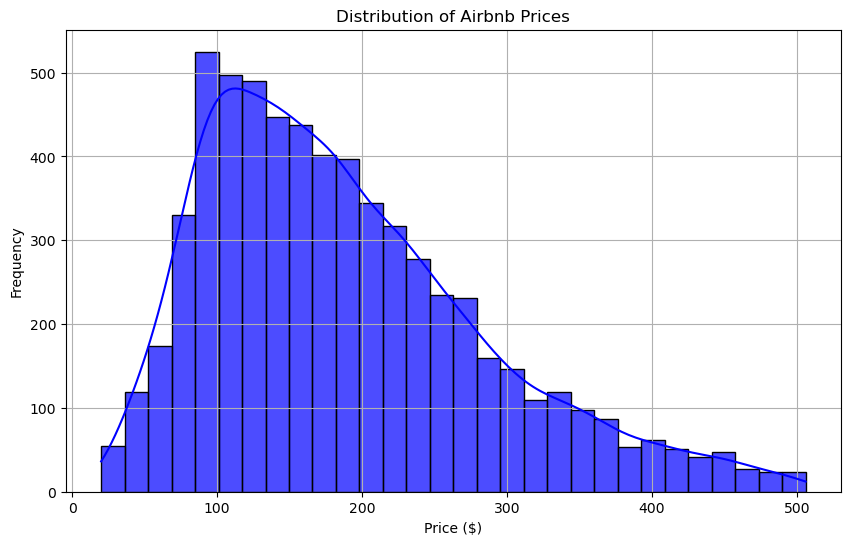

/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/1931670065.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neighborhood_counts.index, y=neighborhood_counts.values, palette="Set2")  # 'Set2' for colorblind-friendly colors


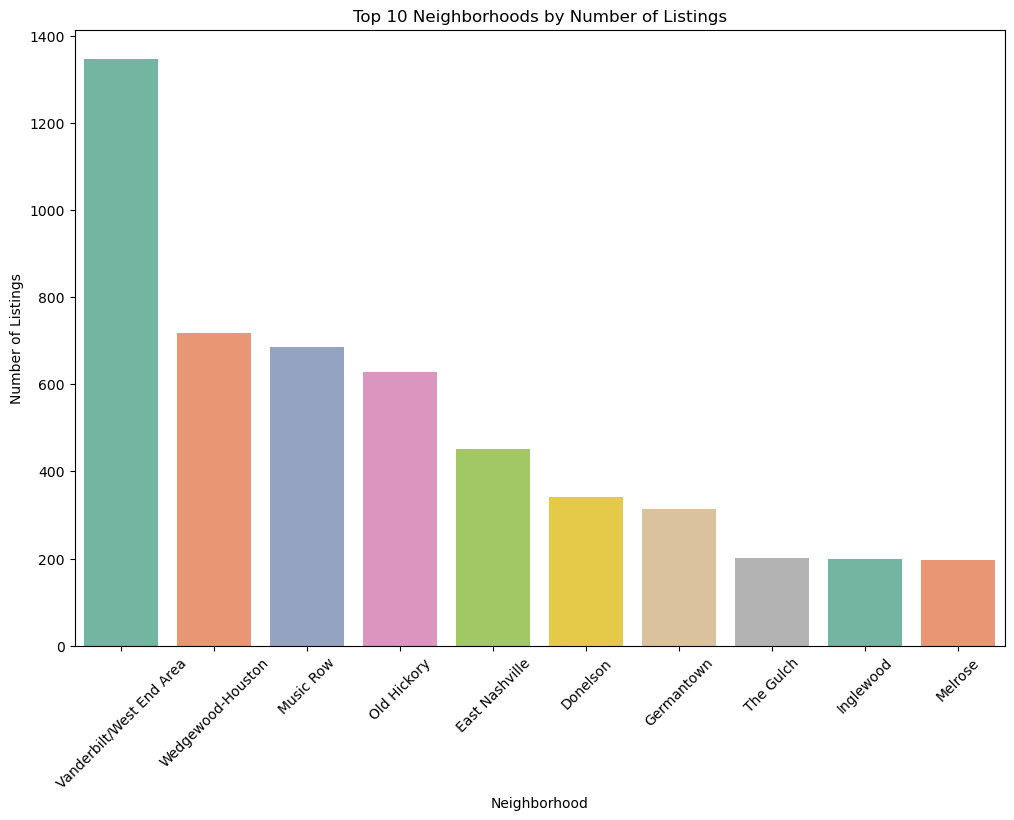

/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/1931670065.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


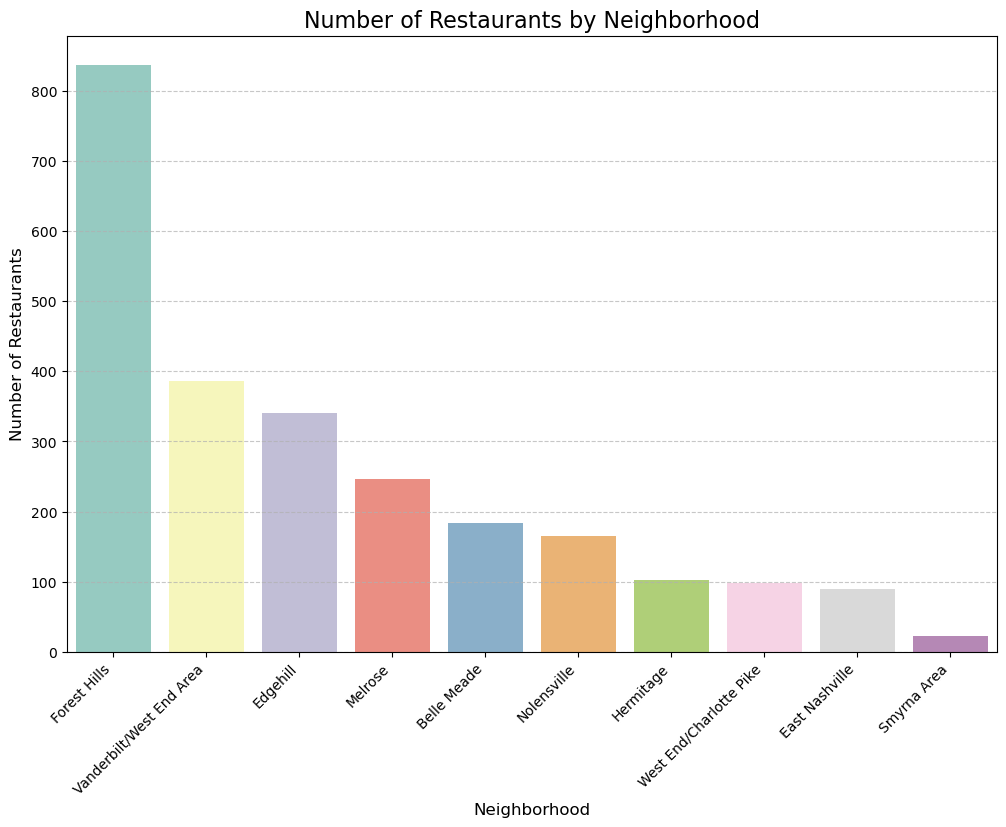

/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/1931670065.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


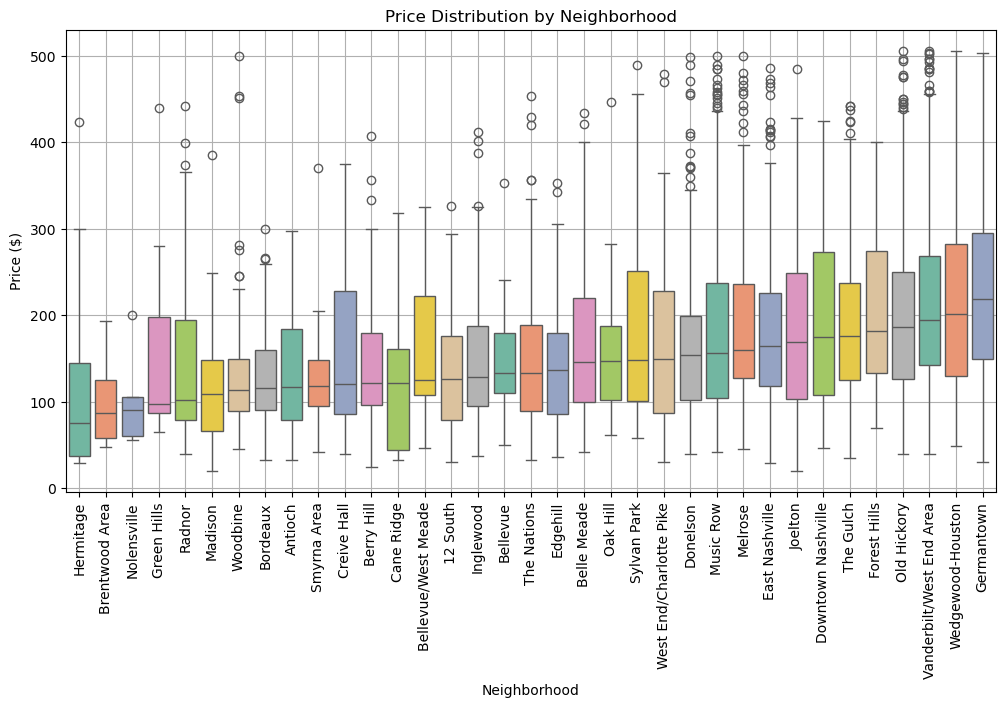

/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/1931670065.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/1931670065.py:63: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.5`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


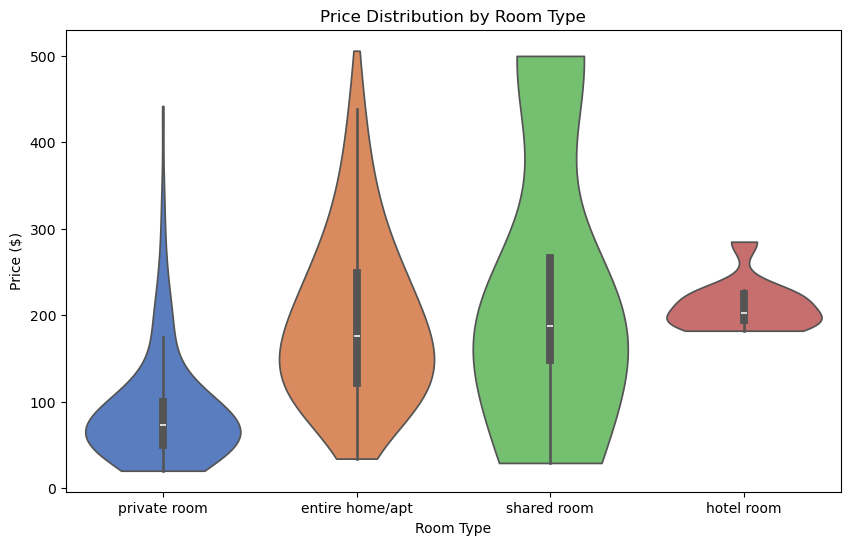

In [226]:
# Code by Alara
# Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(listings_df['price'], bins=30, color='blue', kde=True, alpha=0.7)
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Code by Mary
# Number of Listings by Neighborhood with colorblind-friendly palette
neighborhood_counts = listings_df['neighbourhood_name'].value_counts().head(10)  # Top 10 neighborhoods
plt.figure(figsize=(12, 8))
sns.barplot(x=neighborhood_counts.index, y=neighborhood_counts.values, palette="Set2")  # 'Set2' for colorblind-friendly colors
plt.title('Top 10 Neighborhoods by Number of Listings')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()

# Code by Seema 
# Number of Restaurants by Neighborhood
restaurant_counts = restaurants_with_neighborhoods['neighbourhood_name'].value_counts().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(
    x=restaurant_counts.index, 
    y=restaurant_counts.values, 
    palette="Set3"
)
plt.title('Top 10 Neighborhoods by Number of Restaurants', fontsize=16)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Number of Restaurants', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Code by Mary
# Boxplot: Prices by Neighborhood
# Sort neighborhoods by median price
median_prices = listings_df.groupby('neighbourhood_name')['price'].median().sort_values()
sorted_neighborhoods = median_prices.index

# Update the order of neighborhoods in the DataFrame
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='neighbourhood_name', 
    y='price', 
    data=listings_df, 
    order=sorted_neighborhoods,  # Apply the sorted order
    palette='Set2'
)
plt.xticks(rotation=90)
plt.title('Price Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

# Code by Mary
# Violin plot: Price Distribution by Room Type and KDE clipped to prevent negative values
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='room_type', 
    y='price', 
    data=listings_df, 
    palette='muted', 
    bw=0.5,  # Smaller bandwidth
    cut=0
)
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.show()



This script performs a multi-faceted analysis of Airbnb listings to evaluate neighborhood performance in Nashville. It calculates walkability scores based on proximity to restaurants, neighborhood quality from nearby businesses' ratings, and a confidence-weighted "Bang for Buck" metric that incorporates normalized walkability, neighborhood quality, and popularity metrics relative to price. These metrics are visualized using a Folium map for geographical insights and statistical plots for detailed analysis. The outputs help identify top-performing neighborhoods and visualize the distribution of value for potential renters or stakeholders.

/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/3677045531.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  business_gdf.geometry.distance(listing.geometry) <= radius
/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/3677045531.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  business_gdf.geometry.distance(listing.geometry) <= radius
/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/3677045531.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  business_gdf.geometry.distance(listing.geometry) <= radius
/var/folders/

/var/folders/8y/lz2cmmrs139f0zp2rsjcpy1h0000gn/T/ipykernel_63067/3677045531.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


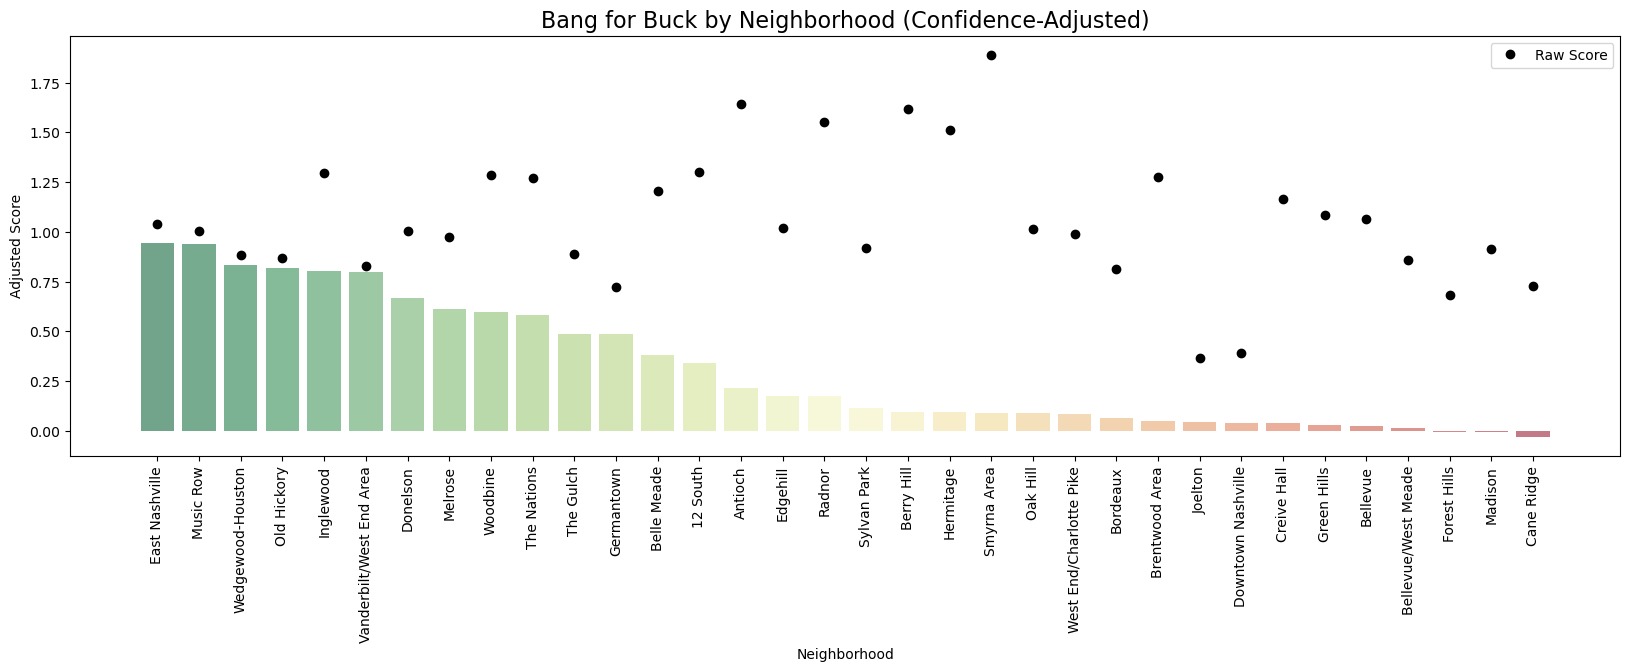


Top 5 Neighbourhoods by Bang for Buck Score:
   neighbourhood_name  bang_for_buck  raw_score  review_count  \
0      East Nashville       0.943241   1.041607           406   
9           Music Row       0.938102   1.004411           572   
8   Wedgewood-Houston       0.836205   0.884091           630   
10        Old Hickory       0.816624   0.869373           548   
5           Inglewood       0.801682   1.296655           171   

    confidence_weight  
0            0.966087  
9            0.993462  
8            0.996334  
10           0.991696  
5            0.693673  


In [224]:

# === Walkability Calculation === Code by Mary
def calculate_walkability(listings_df, businesses_df):
    restaurant_coords = restaurants_df[['latitude', 'longitude']].values
    tree = KDTree(restaurant_coords)
    walkability_distances = []

    for idx, listing in listings_df.iterrows():
        listing_coords = (listing['latitude'], listing['longitude'])
        distances, _ = tree.query([listing_coords], k=5)
        walkability_distances.append(float(min(distances[0])))

    return walkability_distances

# === Bang for Your Buck Analysis with Enhanced Features === Code by Seema
def calculate_neighborhood_quality(listings_gdf, businesses_df, radius=0.01):
    businesses_df['geometry'] = businesses_df.apply(
        lambda row: Point(row['longitude'], row['latitude']), axis=1
    )
    business_gdf = gpd.GeoDataFrame(businesses_df, geometry='geometry', crs="EPSG:4326")
    
    neighborhood_quality = []
    for _, listing in listings_gdf.iterrows():
        nearby_businesses = business_gdf[
            business_gdf.geometry.distance(listing.geometry) <= radius
        ]
        if len(nearby_businesses) > 0:
            weighted_stars = float(
                (nearby_businesses['stars'] * nearby_businesses['review_count']).sum() /
                nearby_businesses['review_count'].sum()
            )
            neighborhood_quality.append(weighted_stars)
        else:
            neighborhood_quality.append(0.0)
    return neighborhood_quality

def calculate_listing_confidence_weight(review_count, min_reviews=5):
    """Calculate confidence weight for an individual listing based on review count"""
    if review_count < min_reviews:
        return 0.2  # Low confidence for listings with few reviews
    return 2 / (1 + np.exp(-review_count/20)) - 1  # Steeper curve for individual listings

def calculate_confidence_adjusted_score(group_data, confidence_level=0.95):
    n = len(group_data)
    if n < 2:
        return group_data.mean(), 0, 0
    
    mean = group_data.mean()
    se = stats.sem(group_data)
    ci = stats.t.interval(confidence_level, n-1, loc=mean, scale=se)
    conservative_score = ci[0]
    
    return mean, conservative_score, n

def calculate_weighted_bang_for_buck(listings_gdf):
    MIN_REVIEWS = 5
    neighborhood_stats = []
    
    for neighborhood in listings_gdf['neighbourhood_name'].unique():
        neighborhood_data = listings_gdf[listings_gdf['neighbourhood_name'] == neighborhood]
        
        if len(neighborhood_data) < MIN_REVIEWS:
            continue
            
        # Calculate raw scores only for listings with sufficient reviews
        qualified_listings = neighborhood_data[neighborhood_data['number_of_reviews'] >= MIN_REVIEWS]
        if len(qualified_listings) < MIN_REVIEWS:
            continue
            
        raw_scores = (
            qualified_listings['normalized_walkability'] * 0.3 +
            qualified_listings['normalized_neighborhood_quality'] * 0.3 +
            qualified_listings['normalized_popularity'] * 0.4
        ) / qualified_listings['normalized_price']
        
        mean_score, conservative_score, n_reviews = calculate_confidence_adjusted_score(raw_scores)
        review_weight = 2 / (1 + np.exp(-n_reviews/100)) - 1
        final_score = conservative_score * review_weight
        
        neighborhood_stats.append({
            'neighbourhood_name': neighborhood,
            'bang_for_buck': final_score,
            'raw_score': mean_score,
            'review_count': n_reviews,
            'confidence_weight': review_weight
        })
    
    return pd.DataFrame(neighborhood_stats)

def prepare_geojson(gdf):
    features = []
    for idx, row in gdf.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': row['geometry'].__geo_interface__,
            'properties': {
                'neighbourhood_name': row['neighbourhood_name']
            }
        }
        features.append(feature)
    return {'type': 'FeatureCollection', 'features': features}

def create_neighborhood_map():
    neighborhood_map = folium.Map(location=[36.1627, -86.7816], zoom_start=10, tiles="CartoDB positron")
    
    min_bfb = float(neighborhood_stats['bang_for_buck'].min())
    max_bfb = float(neighborhood_stats['bang_for_buck'].max())
    colormap = cm.LinearColormap(
        colors=['red', 'yellow', 'green'],
        vmin=min_bfb,
        vmax=max_bfb,
        caption='Bang for Buck Score (Red=Low, Green=High)'
    )
    
    bfb_dict = neighborhood_stats.set_index('neighbourhood_name')['bang_for_buck'].to_dict()
    weight_dict = neighborhood_stats.set_index('neighbourhood_name')['confidence_weight'].to_dict()
    
    neighborhoods_json = prepare_geojson(neighborhoods_gdf)
    
    def style_function(feature):
        neighborhood = feature['properties']['neighbourhood_name']
        bfb_score = bfb_dict.get(neighborhood, 0)
        opacity = weight_dict.get(neighborhood, 0.2)
        return {
            'fillColor': colormap(bfb_score) if bfb_score > 0 else 'gray',
            'color': 'black',
            'weight': 1,
            'fillOpacity': opacity
        }
    
    folium.GeoJson(
        neighborhoods_json,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['neighbourhood_name'],
            aliases=['Neighborhood:'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    ).add_to(neighborhood_map)
    
    colormap.add_to(neighborhood_map)
    return neighborhood_map

def create_statistical_plots():
    plt.figure(figsize=(20, 12))
    
    # First subplot: Bang for Buck
    plt.subplot(2, 1, 1)
    sns.barplot(
        data=neighborhood_stats.sort_values('bang_for_buck', ascending=False),
        x='neighbourhood_name',
        y='bang_for_buck',
        palette='RdYlGn_r',
        alpha=0.6
    )
    
    plt.plot(
        range(len(neighborhood_stats)),
        neighborhood_stats.sort_values('bang_for_buck', ascending=False)['raw_score'],
        'ko',
        label='Raw Score'
    )
    
    plt.title('Bang for Buck by Neighborhood (Confidence-Adjusted)', fontsize=16)
    plt.xticks(rotation=90)
    plt.xlabel('Neighborhood')
    plt.ylabel('Adjusted Score')
    plt.legend()
    
    return plt

# === Data Preparation ===
# Add walkability scores
listings_df['walkability_distance_meters'] = calculate_walkability(listings_df, restaurants_df)

# Prepare GeoDataFrame
listings_df['geometry'] = listings_df.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)
listings_gdf = gpd.GeoDataFrame(listings_df, geometry='geometry', crs="EPSG:4326")

# Add neighborhood names to neighborhoods_gdf if it doesn't have them
if 'neighbourhood_name' not in neighborhoods_gdf.columns:
    neighborhoods_gdf['neighbourhood_name'] = neighborhoods_gdf['neighbourhood'].map(district_locations)
    neighborhoods_gdf['neighbourhood_name'] = neighborhoods_gdf['neighbourhood_name'].fillna(neighborhoods_gdf['neighbourhood'])

# Calculate neighborhood quality
listings_gdf['neighborhood_quality'] = calculate_neighborhood_quality(listings_gdf, businesses_df)

# Normalize features
scaler = MinMaxScaler()
listings_gdf['normalized_price'] = scaler.fit_transform(listings_gdf[['price']])
listings_gdf['normalized_walkability'] = scaler.fit_transform(1 / listings_gdf[['walkability_distance_meters']].replace([np.inf, -np.inf], np.nan))

# Modified popularity normalization to handle zero reviews
listings_gdf['review_score'] = listings_gdf[['number_of_reviews', 'reviews_per_month']].fillna(0).sum(axis=1)
listings_gdf['normalized_popularity'] = scaler.fit_transform(listings_gdf[['review_score']])
listings_gdf['normalized_neighborhood_quality'] = scaler.fit_transform(listings_gdf[['neighborhood_quality']])

# Calculate confidence weights for individual listings
listings_gdf['review_weight'] = listings_gdf['number_of_reviews'].apply(calculate_listing_confidence_weight)

# Calculate neighborhood statistics
neighborhood_stats = calculate_weighted_bang_for_buck(listings_gdf)
neighborhood_stats = neighborhood_stats[np.isfinite(neighborhood_stats['bang_for_buck'])]

# === Generate and Display All Visualizations ===
neighborhood_map = create_neighborhood_map()
display(neighborhood_map)

statistical_plots = create_statistical_plots()
plt.show()

print("\nTop 5 Neighbourhoods by Bang for Buck Score:")
print(neighborhood_stats.sort_values('bang_for_buck', ascending=False)[0:5])

This code creates an interactive map that visualizes the average Airbnb prices across Nashville neighborhoods, with colors indicating price levels and opacity reflecting the density of reviews. The map provides insights into neighborhood affordability and popularity, offering a dual perspective on pricing and user engagement for better decision-making.

In [215]:
# Code by Seema
# Calculate Average Price and Review Density
avg_prices = listings_df.groupby('neighbourhood_name')['price'].mean()
review_density = listings_df.groupby('neighbourhood_name')['number_of_reviews'].sum()

# Normalize Values for Visual Scaling
price_scaler = MinMaxScaler()
density_scaler = MinMaxScaler()

normalized_prices = price_scaler.fit_transform(avg_prices.values.reshape(-1, 1)).flatten()
normalized_density = density_scaler.fit_transform(review_density.values.reshape(-1, 1)).flatten()

# Create a DataFrame for Mapping
price_density_df = pd.DataFrame({
    'neighbourhood_name': avg_prices.index,
    'avg_price': avg_prices.values,
    'review_density': review_density.values,
    'normalized_price': normalized_prices,
    'normalized_density': normalized_density
}).set_index('neighbourhood_name')

# Create the Folium Map
price_colormap = cm.LinearColormap(
    ['blue', 'green', 'yellow', 'orange', 'red'],
    vmin=avg_prices.min(),
    vmax=avg_prices.max(),
    caption='Average Price ($)'
)

price_map = folium.Map(location=[36.1627, -86.7816], zoom_start=10, tiles="CartoDB positron")

# Ensure the correct GeoJSON format
neighborhoods_json = prepare_geojson(neighborhoods_gdf)

# Define the Style Function
def style_function(feature):
    neighborhood = feature['properties']['neighbourhood_name']
    price = price_density_df.loc[neighborhood, 'avg_price'] if neighborhood in price_density_df.index else 0
    density = price_density_df.loc[neighborhood, 'normalized_density'] if neighborhood in price_density_df.index else 0.1

    return {
        'fillColor': price_colormap(price) if price > 0 else 'gray',
        'color': 'black',
        'weight': 1,
        'fillOpacity': max(0.2, density)  # Minimum opacity of 0.2
    }

# Add GeoJSON Layer to the Map
folium.GeoJson(
    neighborhoods_json,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['neighbourhood_name'],
        aliases=['Neighborhood:'],
        localize=True
    )
).add_to(price_map)

# Add the Color Scale to the Map
price_colormap.add_to(price_map)

# Display the Map
display(price_map)


The walkability map visualizes the average walkability scores across Nashville's neighborhoods, scaled from 0 to 100 for interpretability. The color intensity reflects the walkability, with blue representing lower scores and red indicating higher scores. Additionally, the opacity corresponds to the density of Airbnb listings, highlighting neighborhoods with more listings through higher opacity. This dual representation enables a clear understanding of which neighborhoods offer convenient access to amenities while also being popular Airbnb destinations.

In [225]:
# Calculate Walkability Score
listings_df['walkability_score'] = 1 / listings_df['walkability_distance_meters'].replace([np.inf, -np.inf], np.nan)

# Code by Seema
# Calculate Average Walkability and Number of Listings per Neighborhood
avg_walkability = listings_df.groupby('neighbourhood_name')['walkability_score'].mean()
num_listings = listings_df.groupby('neighbourhood_name').size()

# Scale Walkability and Listings for Improved Visualization
walkability_scaler = MinMaxScaler(feature_range=(0, 100))  # Scale between 0-100 for interpretability
listings_scaler = MinMaxScaler()

scaled_walkability = walkability_scaler.fit_transform(avg_walkability.values.reshape(-1, 1)).flatten()
scaled_listings = listings_scaler.fit_transform(num_listings.values.reshape(-1, 1)).flatten()

# Create a DataFrame for Mapping
walkability_df = pd.DataFrame({
    'neighbourhood_name': avg_walkability.index,
    'avg_walkability': avg_walkability.values,
    'num_listings': num_listings.values,
    'scaled_walkability': scaled_walkability,
    'scaled_listings': scaled_listings
}).set_index('neighbourhood_name')

# Define Walkability Colormap
walkability_colormap = cm.LinearColormap(
    ['blue', 'green', 'yellow', 'orange', 'red'],
    vmin=0,  # Scaled minimum
    vmax=100,  # Scaled maximum
    caption='Average Walkability (Scaled 0-100)'
)

# Create the Folium Map
walkability_map = folium.Map(location=[36.1627, -86.7816], zoom_start=10, tiles="CartoDB positron")

# Ensure the correct GeoJSON format
neighborhoods_json = prepare_geojson(neighborhoods_gdf)

# Define the Style Function
def style_function(feature):
    neighborhood = feature['properties']['neighbourhood_name']
    walkability = walkability_df.loc[neighborhood, 'scaled_walkability'] if neighborhood in walkability_df.index else 0
    listings_density = walkability_df.loc[neighborhood, 'scaled_listings'] if neighborhood in walkability_df.index else 0.2

    return {
        'fillColor': walkability_colormap(walkability) if walkability > 0 else 'gray',
        'color': 'black',
        'weight': 1,
        'fillOpacity': max(0.2, listings_density)  # Minimum opacity of 0.2
    }

# Add GeoJSON Layer to the Map
folium.GeoJson(
    neighborhoods_json,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['neighbourhood_name'],
        aliases=['Neighborhood:'],
        localize=True
    )
).add_to(walkability_map)

# Add the Color Scale to the Map
walkability_colormap.add_to(walkability_map)

# Display the Map
display(walkability_map)
